Using device: cuda
[Epoch 1, Batch 2000]  loss: 1.984
Epoch 1  ➜  Training Accuracy: 22.54%
Epoch 1  ➜  Test    Accuracy: 31.42%

[Epoch 2, Batch 2000]  loss: 1.631
Epoch 2  ➜  Training Accuracy: 40.37%
Epoch 2  ➜  Test    Accuracy: 47.82%

[Epoch 3, Batch 2000]  loss: 1.360
Epoch 3  ➜  Training Accuracy: 54.73%
Epoch 3  ➜  Test    Accuracy: 59.32%

[Epoch 4, Batch 2000]  loss: 1.343
Epoch 4  ➜  Training Accuracy: 62.18%
Epoch 4  ➜  Test    Accuracy: 63.74%

[Epoch 5, Batch 2000]  loss: 112.546
Epoch 5  ➜  Training Accuracy: 66.33%
Epoch 5  ➜  Test    Accuracy: 64.49%

[Epoch 6, Batch 2000]  loss: 0.956
Epoch 6  ➜  Training Accuracy: 69.63%
Epoch 6  ➜  Test    Accuracy: 69.59%

[Epoch 7, Batch 2000]  loss: 1.529
Epoch 7  ➜  Training Accuracy: 72.64%
Epoch 7  ➜  Test    Accuracy: 70.69%

[Epoch 8, Batch 2000]  loss: 0.994
Epoch 8  ➜  Training Accuracy: 74.70%
Epoch 8  ➜  Test    Accuracy: 70.33%

[Epoch 9, Batch 2000]  loss: 6.884
Epoch 9  ➜  Training Accuracy: 77.02%
Epoch 9  ➜  Test  

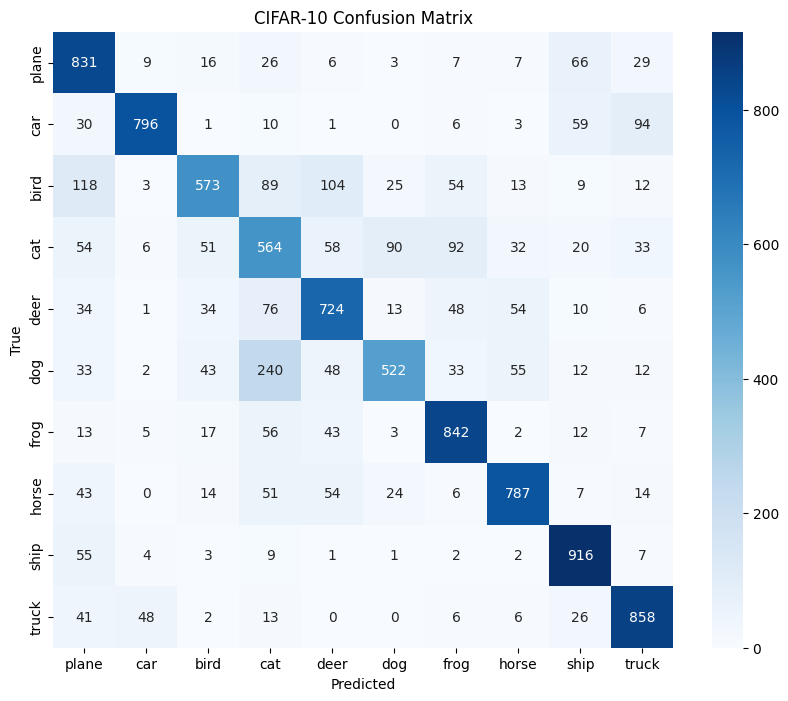

In [21]:
import torch
import torchvision
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# === Feature flags ===
use_dropout            = True
use_leaky_relu         = True
use_grad_clipped_relu  = True # applies gradient clipping if True
use_batchnorm          =False

# === Hyperparams ===
batch_size = 16
lr         = 1e-3
momentum   = 0.9
num_epochs = 20
grad_clip_max_norm = 1.0

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Data transforms ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# === Datasets & loaders ===
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,  num_workers=2)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

# === Model definition ===
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers
        self.conv1 = nn.Conv2d(3,    32, 5, padding=2)
        self.conv2 = nn.Conv2d(32,   64, 5, padding=2)
        self.conv3 = nn.Conv2d(64,  128, 5, padding=2)
        self.conv4 = nn.Conv2d(128, 128, 5, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 5, padding=2)
        self.conv6 = nn.Conv2d(256, 256, 5, padding=2)
        self.conv7 = nn.Conv2d(256, 512, 5, padding=2)

        # ... rest of code unchanged ... 

        self.pool = nn.MaxPool2d(2, 2)

        # optional batchnorm
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(32)
            self.bn2 = nn.BatchNorm2d(64)
            self.bn3 = nn.BatchNorm2d(128)
            self.bn4 = nn.BatchNorm2d(128)
            self.bn5 = nn.BatchNorm2d(256)
            self.bn6 = nn.BatchNorm2d(256)
            self.bn7 = nn.BatchNorm2d(512)

        # fully connected
        self.fc1 = nn.Linear(512 * 1 * 1, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)

        if use_batchnorm:
            self.bn_fc1 = nn.BatchNorm1d(120)
            self.bn_fc2 = nn.BatchNorm1d(84)

        if use_dropout:
            self.drop = nn.Dropout(p=0.2)

        if use_leaky_relu:
            self.lrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, x):
        act = self.lrelu if use_leaky_relu else F.relu

        x = self.conv1(x)
        if use_batchnorm: x = self.bn1(x)
        x = act(x)
        x = self.pool(x)

        x = self.conv2(x)
        if use_batchnorm: x = self.bn2(x)
        x = act(x)
        x = self.pool(x)

        x = self.conv3(x)
        if use_batchnorm: x = self.bn3(x)
        x = act(x)

        x = self.conv4(x)
        if use_batchnorm: x = self.bn4(x)
        x = act(x)
        x = self.pool(x)

        x = self.conv5(x)
        if use_batchnorm: x = self.bn5(x)
        x = act(x)

        x = self.conv6(x)
        if use_batchnorm: x = self.bn6(x)
        x = act(x)
        x = self.pool(x)

        x = self.conv7(x)
        if use_batchnorm: x = self.bn7(x)
        x = act(x)
        x = self.pool(x)

        x = x.view(-1, 512 * 1 * 1)

        x = self.fc1(x)
        if use_batchnorm: x = self.bn_fc1(x)
        x = act(x)
        if use_dropout: x = self.drop(x)

        x = self.fc2(x)
        if use_batchnorm: x = self.bn_fc2(x)
        x = act(x)
        if use_dropout: x = self.drop(x)

        x = self.fc3(x)
        return x

net = Net().to(device)


# === Loss & optimizer ===
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(net.parameters(), lr=lr)

# === Training loop ===
for epoch in range(1, num_epochs+1):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train   = 0

    for i, (inputs, labels) in enumerate(trainloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # print(inputs.shape)
        outputs = net(inputs)
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()

        if use_grad_clipped_relu:
            torch.nn.utils.clip_grad_norm_(net.parameters(), grad_clip_max_norm)

        optimizer.step()

        # accumulate loss
        running_loss += loss.item()
        # training accuracy
        _, preds = outputs.max(1)
        correct_train += (preds == labels).sum().item()
        total_train   += labels.size(0)

        if i % 2000 == 0:
            avg_loss = running_loss / 2000
            print(f"[Epoch {epoch}, Batch {i}]  loss: {avg_loss:.3f}")
            running_loss = 0.0

    train_acc = 100 * correct_train / total_train
    print(f"Epoch {epoch}  ➜  Training Accuracy: {train_acc:.2f}%")

    # --- evaluate on test set each epoch ---
    net.eval()
    correct_test = 0
    total_test   = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, preds = outputs.max(1)
            correct_test += (preds == labels).sum().item()
            total_test   += labels.size(0)
    test_acc = 100 * correct_test / total_test
    print(f"Epoch {epoch}  ➜  Test    Accuracy: {test_acc:.2f}%\n")

print("Finished Training\n")

# === Final evaluation & confusion matrix ===
all_labels = []
all_preds  = []

net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CIFAR-10 Confusion Matrix')
plt.show()
